# Attention-Based Image Reconstruction Model

This file implements an attention-based deep learning model for image reconstruction. It includes:

- Model definition with spatial and channel attention mechanisms.
- Custom loss function combining MSE and MAE.
- Training and evaluation loops to measure model performance.
- Utilities for visualization, pixel replacement, and saving the model.

The code is designed to efficiently train and evaluate the model on masked and original images, with support for GPU acceleration.

---
## Import Required Libraries

This block initializes the project environment, ensuring necessary libraries and configurations are in place.

In [17]:
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
import os
import torch
import dill
import warnings
warnings.filterwarnings("ignore", message=".*cudnnException.*")

# Define Dataset Class
We create a custom dataset class to load pairs of original and masked images. The images are assumed to have the same name, with `_masked` appended to the masked image files.

In [18]:
class ImageMaskDataset(Dataset):
 
    def __init__(self, directory, transform=None, augment=False):
        self.directory = directory
        self.transform = transform
        self.augment = augment
        self.image_files = [f for f in os.listdir(directory) if not f.endswith("_masked.jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        original_name = self.image_files[idx]
        masked_name = original_name.replace(".jpg", "_masked.jpg")

        original_path = os.path.join(self.directory, original_name)
        masked_path = os.path.join(self.directory, masked_name)

        # Load images
        original_img = Image.open(original_path).convert("RGB")
        masked_img = Image.open(masked_path).convert("RGB")

        # Apply augmentations if enabled
        if self.augment:
            # Random Horizontal Flip
            if random.random() > 0.5:
                original_img = TF.hflip(original_img)
                masked_img = TF.hflip(masked_img)

            # Random Rotation
            angle = random.uniform(-30, 30)  # Reduce rotation range for subtle changes
            original_img = TF.rotate(original_img, angle)
            masked_img = TF.rotate(masked_img, angle)

            # Random Crop with Padding
            i, j, h, w = transforms.RandomCrop.get_params(original_img, output_size=(224, 224))
            original_img = TF.crop(original_img, i, j, h, w)
            masked_img = TF.crop(masked_img, i, j, h, w)

        # Apply basic transformations (e.g., ToTensor, normalization)
        if self.transform:
            original_img = self.transform(original_img)
            masked_img = self.transform(masked_img)

        return masked_img, original_img

# Define transformations to normalize image pixels to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors (auto-normalized to [0, 1])
])

# Base directory for the dataset
base_dir = os.path.join("..", "Dataset")

# Directories for train, validation, and test sets
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Initialize datasets
train_dataset = ImageMaskDataset(train_dir, transform=transform, augment=True)  # Enable augmentation for training
val_dataset = ImageMaskDataset(val_dir, transform=transform, augment=False)     # No augmentation for validation
test_dataset = ImageMaskDataset(test_dir, transform=transform, augment=False)   # No augmentation for testing

# Data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify dataset sizes and loader functionality
print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 9440, Validation samples: 1350, Test samples: 2710


---
## The Model with Attention Mechanisms

This block defines a custom image reconstruction model incorporating attention mechanisms (spatial and channel attention) and residual connections. The architecture is designed to enhance feature representation and improve the quality of image reconstruction. Below are the main components and their roles:

### 1. ResidualBlock
- **Purpose**: Implements residual connections to ease the training of deep networks by enabling gradient flow and addressing the vanishing gradient problem.
- **Details**: Consists of two convolutional layers with Batch Normalization and a ReLU activation function. The input is added to the output to form a residual connection.

### 2. ChannelAttention
- **Purpose**: Focuses on enhancing important channels in the feature map while suppressing less relevant ones.
- **Details**: Utilizes global average pooling followed by two fully connected layers and a Sigmoid activation to generate channel-wise attention weights.

### 3. SpatialAttention
- **Purpose**: Emphasizes important spatial regions in the feature map by analyzing the spatial context.
- **Details**: Takes the mean and max across channels, concatenates them, and applies a convolutional layer followed by a Sigmoid activation to generate spatial attention weights.

### 4. ImageReconstructionModel
- **Structure**: Composed of three main parts: Encoder, Bottleneck, and Decoder.
  - **Encoder**: Extracts features from the input image at multiple scales using convolutional layers, attention mechanisms, and downsampling.
    - `encoder1`: First encoding stage with spatial attention and dropout for regularization.
    - `encoder2` & `encoder3`: Subsequent encoding stages with channel attention for enhanced feature representation.
  - **Bottleneck**: Utilizes residual blocks to refine features while maintaining the scale.
  - **Decoder**: Reconstructs the image using upsampling and residual blocks while incorporating skip connections.
    - `decoder1` & `decoder2`: Reconstruct intermediate features with spatial attention and PixelShuffle for upsampling.
    - `decoder3`: Final reconstruction with normalization using Sigmoid activation.
  - **Skip Connections**: Pass features from the encoder to the decoder, ensuring information retention at multiple scales.
    - `skip1` & `skip2`: Adjust channel dimensions and refine skip features using attention and residual blocks.
  - **Refinement Layer**: Enhances the reconstructed image by adding fine details using additional residual blocks.

### 5. Model Initialization
- The model is instantiated and moved to the available device (GPU if available, otherwise CPU).



In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        # Define the sequence of layers for the residual block
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),  # First convolutional layer
            nn.BatchNorm2d(channels),  # Batch normalization for stabilizing training
            nn.ReLU(inplace=True),  # ReLU activation for non-linearity
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),  # Second convolutional layer
            nn.BatchNorm2d(channels)  # Batch normalization after the second convolution
        )

    def forward(self, x):
        # Add the input (residual connection) to the processed output
        return x + self.block(x)

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        # Define the channel attention mechanism
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling to reduce spatial dimensions
            nn.Conv2d(channels, channels // reduction, kernel_size=1),  # First FC layer to reduce channels
            nn.ReLU(inplace=True),  # ReLU activation for non-linearity
            nn.Conv2d(channels // reduction, channels, kernel_size=1),  # Second FC layer to restore channel dimensions
            nn.Sigmoid()  # Sigmoid activation to generate attention weights
        )

    def forward(self, x):
        # Generate attention weights and apply them to the input
        attention_weights = self.attention(x)
        return x * attention_weights

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        # Define the spatial attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size // 2), bias=False),  # Single convolutional layer
            nn.Sigmoid()  # Sigmoid activation to generate spatial attention weights
        )

    def forward(self, x):
        # Calculate average and maximum along the channel dimension
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling across channels
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling across channels
        attention_input = torch.cat([avg_out, max_out], dim=1)  # Concatenate along the channel dimension
        attention_weights = self.attention(attention_input)  # Apply spatial attention
        return x * attention_weights

class ImageReconstructionModel(nn.Module):
    def __init__(self):
        super(ImageReconstructionModel, self).__init__()

        # Define the encoder blocks
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Downsample input to 64 channels
            nn.ReLU(inplace=True),  # ReLU activation
            SpatialAttention(kernel_size=7),  # Spatial attention mechanism
            nn.Dropout(0.2)  # Dropout for regularization
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Downsample to 128 channels
            nn.BatchNorm2d(128),  # Batch normalization for stability
            nn.ReLU(inplace=True),  # ReLU activation
            ChannelAttention(128),  # Channel attention mechanism
            nn.Dropout(0.2)  # Dropout for regularization
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Downsample to 256 channels
            nn.BatchNorm2d(256),  # Batch normalization for stability
            nn.ReLU(inplace=True),  # ReLU activation
            ChannelAttention(256),  # Channel attention mechanism
            nn.Dropout(0.2)  # Dropout for regularization
        )

        # Bottleneck block with residual connections
        self.bottleneck = nn.Sequential(
            ResidualBlock(256),  # First residual block
            ResidualBlock(256),  # Second residual block
            ResidualBlock(256)  # Third residual block
        )

        # Define the decoder blocks
        self.decoder1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Expand channels before upsampling
            nn.PixelShuffle(upscale_factor=2),  # Upsampling using PixelShuffle
            nn.BatchNorm2d(128),  # Batch normalization after upsampling
            nn.ReLU(inplace=True),  # ReLU activation
            ResidualBlock(128),  # Residual block for feature refinement
            SpatialAttention(kernel_size=7)  # Spatial attention mechanism
        )
        self.decoder2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Expand channels before upsampling
            nn.PixelShuffle(upscale_factor=2),  # Upsampling using PixelShuffle
            nn.BatchNorm2d(64),  # Batch normalization after upsampling
            nn.ReLU(inplace=True),  # ReLU activation
            ResidualBlock(64),  # Residual block for feature refinement
            SpatialAttention(kernel_size=7)  # Spatial attention mechanism
        )
        self.decoder3 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),  # Final upsampling preparation
            nn.PixelShuffle(upscale_factor=2),  # Final upsampling using PixelShuffle
            nn.Sigmoid()  # Sigmoid activation to normalize output to [0, 1]
        )

        # Skip connections
        self.skip1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),  # Adjust channels for skip connection
            nn.BatchNorm2d(128),  # Batch normalization for stability
            ChannelAttention(128),  # Channel attention for skip connection
            ResidualBlock(128)  # Residual refinement for skip features
        )
        self.skip2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1),  # Adjust channels for skip connection
            nn.BatchNorm2d(256),  # Batch normalization for stability
            ChannelAttention(256),  # Channel attention for skip connection
            ResidualBlock(256)  # Residual refinement for skip features
        )

        # Refinement layer
        self.refinement = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=3, padding=1),  # Adjust input channels for refinement
            nn.ReLU(inplace=True),  # ReLU activation
            ResidualBlock(64),  # Residual block for refinement
            ResidualBlock(64),  # Additional refinement block
            nn.Conv2d(64, 3, kernel_size=3, padding=1),  # Final output layer with 3 channels
            nn.Sigmoid()  # Sigmoid activation to normalize output to [0, 1]
        )

    def forward(self, x):
        # Forward pass through the encoder
        enc1 = self.encoder1(x)  # First encoding stage
        enc2 = self.encoder2(enc1)  # Second encoding stage
        enc3 = self.encoder3(enc2)  # Third encoding stage

        # Bottleneck processing
        bottlenecked = self.bottleneck(enc3)  # Pass through bottleneck blocks

        # Skip connection from encoder2
        aligned_enc2 = nn.functional.interpolate(enc2, size=bottlenecked.shape[2:], mode="bilinear", align_corners=False)
        aligned_enc2 = self.skip2(aligned_enc2)  # Refine encoder2 features

        # Decoder stage 1
        dec1 = self.decoder1(bottlenecked + aligned_enc2)  # Combine bottleneck and refined encoder2 features

        # Skip connection from encoder1
        aligned_enc1 = nn.functional.interpolate(enc1, size=dec1.shape[2:], mode="bilinear", align_corners=False)
        aligned_enc1 = self.skip1(aligned_enc1)  # Refine encoder1 features

        # Decoder stage 2
        dec2 = self.decoder2(dec1 + aligned_enc1)  # Combine decoder1 and refined encoder1 features

        # Final reconstruction
        dec3 = self.decoder3(dec2)  # Reconstruct the image

        # Refinement for fine details
        refined = self.refinement(dec3)  # Apply final refinement for output

        return refined

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model = ImageReconstructionModel().to(device)  # Move model to the chosen device
print(model)  # Print the model architecture

ImageReconstructionModel(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): SpatialAttention(
      (attention): Sequential(
        (0): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): Sigmoid()
      )
    )
    (3): Dropout(p=0.2, inplace=False)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ChannelAttention(
      (attention): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(128, 8, kernel_size=(1, 1), stride=(1, 1))
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 128, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
    )
    (4): Dropout(p=0.2, inplace=False)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kerne


---
## Training and Validation Loop

This block trains the image reconstruction model using a combined loss function (MSE and MAE). The training includes:

- **Combined Loss Function**: Balances Mean Squared Error (MSE) and Mean Absolute Error (MAE) with configurable weights.
- **Optimizer & Scheduler**: Adam optimizer with a StepLR scheduler to adjust learning rates every 20 epochs.
- **Training Phase**: The model is trained on masked images to minimize reconstruction loss using backpropagation.
- **Validation Phase**: Evaluates model performance on validation data without updating weights.
- **Logging**: Tracks and prints training and validation losses for each epoch.

This setup runs for 400 epochs, leveraging a GPU (if available) for efficient training.


In [20]:
# Define the combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.5, mae_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()  # Mean Squared Error loss
        self.mae_loss = nn.L1Loss()  # Mean Absolute Error loss
        self.mse_weight = mse_weight  # Weight for MSE
        self.mae_weight = mae_weight  # Weight for MAE

    def forward(self, outputs, target):
        mse = self.mse_loss(outputs, target)  # Compute MSE
        mae = self.mae_loss(outputs, target)  # Compute MAE
        return self.mse_weight * mse + self.mae_weight * mae  # Weighted combination of both losses

# Instantiate the loss function with equal weights for MSE and MAE
loss_fn = CombinedLoss(mse_weight=0.5, mae_weight=0.5)

# Adjusted Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, else CPU
model = model.to(device)  # Move the model to the appropriate device

# Define optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer with initial learning rate of 0.01
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)  # Reduce learning rate every 20 epochs

history = {"train_loss": [], "val_loss": []}  # Dictionary to store training and validation loss history
epochs = 400  # Total number of training epochs

for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0  # Initialize training loss for the epoch

    # Training phase
    for masked_image, original_image in train_loader:
        # Move input and target to the selected device
        masked_image, original_image = masked_image.to(device), original_image.to(device)

        optimizer.zero_grad()  # Reset gradients
        # Forward pass: Generate predictions
        outputs = model(masked_image)

        # Compute the combined loss
        loss = loss_fn(outputs, original_image)

        # Backward pass: Compute gradients and update weights
        loss.backward()
        optimizer.step()

        train_loss += loss.item()  # Accumulate training loss for the batch

    train_loss /= len(train_loader)  # Compute average training loss for the epoch
    history["train_loss"].append(train_loss)  # Save training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Initialize validation loss for the epoch
    with torch.no_grad():  # Disable gradient computation for validation
        for masked_image, original_image in val_loader:
            # Move input and target to the selected device
            masked_image, original_image = masked_image.to(device), original_image.to(device)
            outputs = model(masked_image)  # Forward pass
            loss = loss_fn(outputs, original_image)  # Compute validation loss
            val_loss += loss.item()  # Accumulate validation loss for the batch

    val_loss /= len(val_loader)  # Compute average validation loss for the epoch
    history["val_loss"].append(val_loss)  # Save validation loss

    # Print loss values for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    scheduler.step()  # Update learning rate based on the scheduler

Epoch 1/400, Train Loss: 0.1479, Val Loss: 0.0661
Epoch 2/400, Train Loss: 0.0527, Val Loss: 0.0476
Epoch 3/400, Train Loss: 0.0447, Val Loss: 0.0452
Epoch 4/400, Train Loss: 0.0418, Val Loss: 0.0420
Epoch 5/400, Train Loss: 0.0403, Val Loss: 0.0407
Epoch 6/400, Train Loss: 0.0352, Val Loss: 0.0411
Epoch 7/400, Train Loss: 0.0298, Val Loss: 0.0348
Epoch 8/400, Train Loss: 0.0288, Val Loss: 0.0302
Epoch 9/400, Train Loss: 0.0287, Val Loss: 0.0263
Epoch 10/400, Train Loss: 0.0277, Val Loss: 0.0272
Epoch 11/400, Train Loss: 0.0271, Val Loss: 0.0295
Epoch 12/400, Train Loss: 0.0269, Val Loss: 0.0267
Epoch 13/400, Train Loss: 0.0262, Val Loss: 0.0238
Epoch 14/400, Train Loss: 0.0240, Val Loss: 0.0223
Epoch 15/400, Train Loss: 0.0231, Val Loss: 0.0253
Epoch 16/400, Train Loss: 0.0224, Val Loss: 0.0264
Epoch 17/400, Train Loss: 0.0224, Val Loss: 0.0199
Epoch 18/400, Train Loss: 0.0224, Val Loss: 0.0244
Epoch 19/400, Train Loss: 0.0215, Val Loss: 0.0212
Epoch 20/400, Train Loss: 0.0220, Val Lo

---
## Plotting Training and Validation Losses

This block visualizes the training and validation loss trends over epochs to assess the model's performance during training. The plot includes:

- **Training Loss**: Monitors how well the model learns during training.
- **Validation Loss**: Tracks the model's performance on unseen data.

The graph helps identify overfitting, underfitting, or convergence issues.


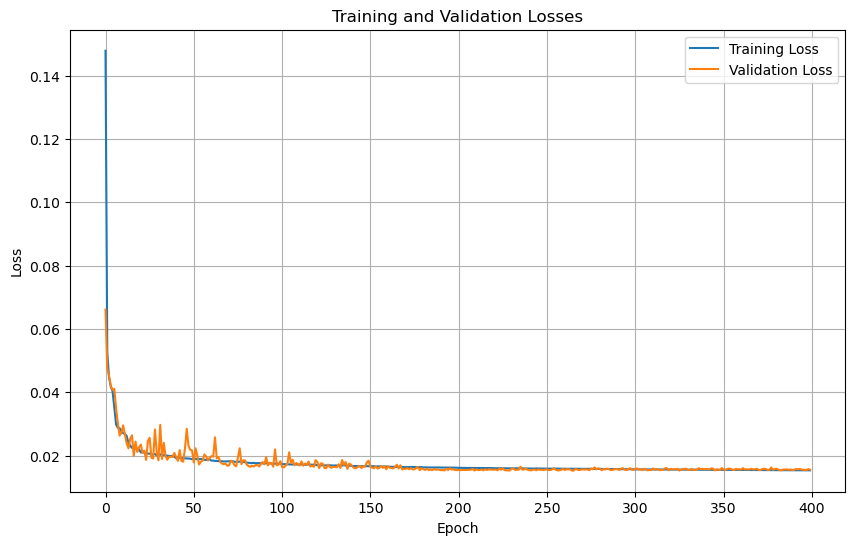

In [21]:
def plot_losses(history):
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(history["train_loss"], label="Training Loss")
    
    # Plot validation loss
    plt.plot(history["val_loss"], label="Validation Loss")
    
    # Add labels, title, and legend
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function
plot_losses(history)


## Test Set Evaluation

This block evaluates the model's performance on the test set by:

- Replacing reconstructed image pixels based on a "blackness" threshold.
- Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for each image pair.
- Printing the average MSE and MAE as final results.


In [22]:
# Helper function to replace colorful pixels in the reconstructed image
def replace_colorful_pixels(masked_image, reconstructed_image, threshold=0.2):
   
    # Convert the masked image to grayscale to evaluate blackness
    grayscale_mask = np.mean(masked_image, axis=0)  # Average across color channels
    replace_condition = grayscale_mask > threshold  # Pixels that are not black enough

    # Replace pixels in the reconstructed image where the condition is met
    reconstructed_image[:, replace_condition] = masked_image[:, replace_condition]

    return reconstructed_image

# Lists to store MSE and MAE for each image
mse_list = []
mae_list = []

# Evaluate on the test set
print("Evaluating the Attention Model on the test set...")
with torch.no_grad():
    for masked_images, original_images in test_loader:
        masked_images = masked_images.to(device)
        original_images = original_images.to(device)

        # Generate reconstructed images using the attention-based model
        reconstructed_images = model(masked_images)

        # Convert to NumPy arrays
        reconstructed_images = reconstructed_images.cpu().numpy()
        original_images = original_images.cpu().numpy()
        masked_images = masked_images.cpu().numpy()

        # Apply the helper function to replace colorful pixels
        for i in range(reconstructed_images.shape[0]):
            reconstructed_images[i] = replace_colorful_pixels(
                masked_images[i], reconstructed_images[i], threshold=0.1
            )

        # Scale to [0, 255] for evaluation
        reconstructed_images = np.clip(reconstructed_images * 255, 0, 255)
        original_images = np.clip(original_images * 255, 0, 255)

        # Compute MSE and MAE for each image pair
        for reconstructed, original in zip(reconstructed_images, original_images):
            mse = np.mean((original - reconstructed) ** 2)  # Per-image MSE
            mae = np.mean(np.abs(original - reconstructed))  # Per-image MAE
            mse_list.append(mse)
            mae_list.append(mae)

# Calculate average MSE and MAE across all images
average_mse = np.mean(mse_list)
average_mae = np.mean(mae_list)

# Print final results
print(f"Test Results - Average MSE: {average_mse:.4f}")
print(f"Test Results - Average MAE: {average_mae:.4f}")

Evaluating the Attention Model on the test set...
Test Results - Average MSE: 63.5878
Test Results - Average MAE: 1.5124



---
## Visualizing Test Set Images and Reconstructions

This block visualizes a grid of masked test set images alongside their reconstructed versions generated by the model. Key details:

- **Input**: Masked images from the test set.
- **Output**: Corresponding reconstructed images.
- **Visualization**: Arranged in a 4-row grid:
  - Rows 1 and 3: Masked test set images.
  - Rows 2 and 4: Reconstructed test set images.


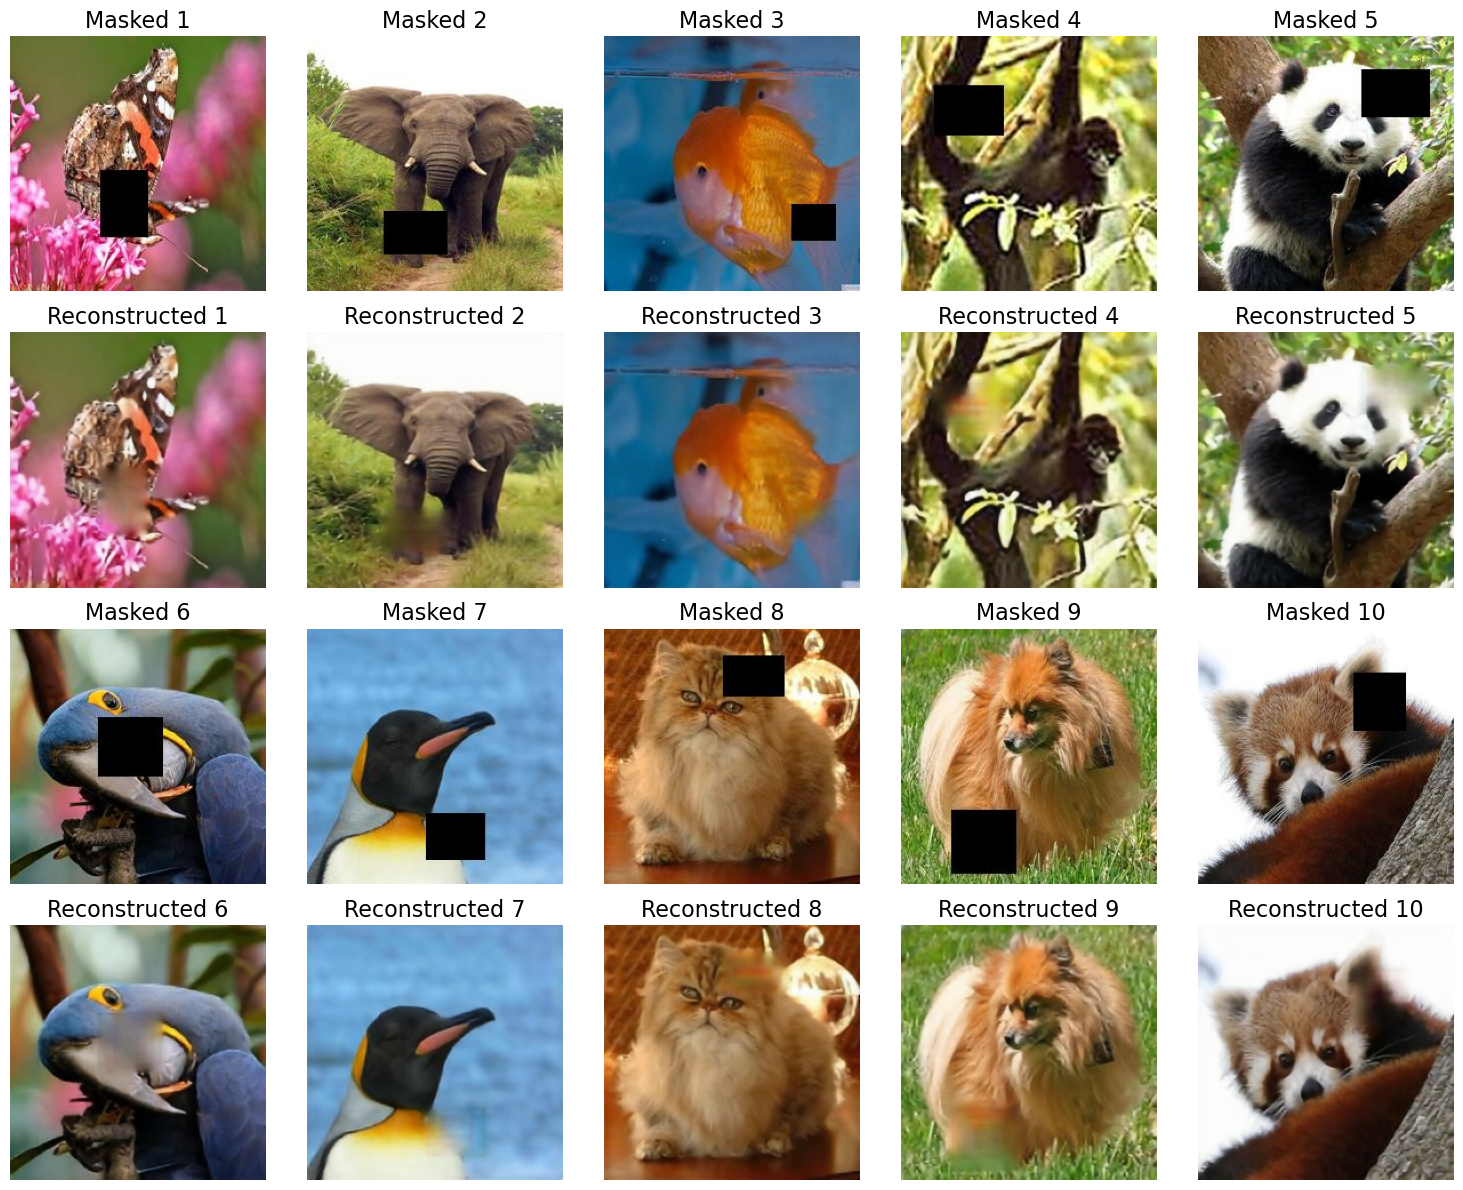

In [23]:
def visualize_reference_images(model, reference_images_dir, transform, grid_size=5):

    model.eval()  # Ensure the model is in evaluation mode

    # Load masked images
    masked_image_files = sorted(os.listdir(reference_images_dir))
    masked_images = []
    for file_name in masked_image_files[:2 * grid_size]:  # Limit to the first 2 * grid_size images
        image_path = os.path.join(reference_images_dir, file_name)
        image = Image.open(image_path).convert("RGB")  # Open image in RGB format
        masked_images.append(transform(image))  # Apply transformations (e.g., ToTensor)

    # Stack into a batch and move to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    masked_images = torch.stack(masked_images).to(device)  # Shape: [batch_size, channels, height, width]

    # Generate reconstructed images
    with torch.no_grad():
        reconstructed_images = model(masked_images)  # Model output
        reconstructed_images = reconstructed_images.cpu()  # Move to CPU for visualization

    # Convert tensors to numpy arrays for processing
    masked_images_np = masked_images.permute(0, 2, 3, 1).cpu().numpy()  # [batch, H, W, C]
    reconstructed_images_np = reconstructed_images.permute(0, 2, 3, 1).numpy()  # [batch, H, W, C]

    # Normalize both masked and reconstructed images to [0, 1] range
    masked_images_np = np.clip(masked_images_np, 0, 1)
    reconstructed_images_np = np.clip(reconstructed_images_np, 0, 1)

    # Scale both masked and reconstructed images to [0, 255] for visualization
    masked_images_np = (masked_images_np * 255).astype(np.uint8)
    reconstructed_images_np = (reconstructed_images_np * 255).astype(np.uint8)

    # Visualization with a 4-row grid
    fig, axs = plt.subplots(4, grid_size, figsize=(15, 12))  # 4 rows, grid_size columns

    # First set of images (rows 1 and 2)
    for i in range(grid_size):
        # Row 1: Masked images
        axs[0, i].imshow(masked_images_np[i])
        axs[0, i].axis("off")
        axs[0, i].set_title(f"Masked {i+1}", fontsize=16)

        # Row 2: Reconstructed images
        axs[1, i].imshow(reconstructed_images_np[i])
        axs[1, i].axis("off")
        axs[1, i].set_title(f"Reconstructed {i+1}", fontsize=16)

    # Second set of images (rows 3 and 4)
    for i in range(grid_size, 2 * grid_size):
        # Row 3: Masked images
        axs[2, i - grid_size].imshow(masked_images_np[i])
        axs[2, i - grid_size].axis("off")
        axs[2, i - grid_size].set_title(f"Masked {i+1}", fontsize=16)

        # Row 4: Reconstructed images
        axs[3, i - grid_size].imshow(reconstructed_images_np[i])
        axs[3, i - grid_size].axis("off")
        axs[3, i - grid_size].set_title(f"Reconstructed {i+1}", fontsize=16)

    plt.tight_layout()
    plt.show()
    
    
# Path to reference images
reference_images_dir = os.path.join("..", "Reference_Images")

# Visualize a few images of the train set
visualize_reference_images(model, reference_images_dir, transform)

# Saving the Model

This block saves the entire attention model, including its architecture and weights, to a specified directory for future use.


In [24]:
import os
import torch

# Assume ImageReconstructionModel is already defined earlier in this training file

# Parent directory for saving models
parent_dir = os.path.join("..", "saved_models", "AttentionModel")

# Create the parent directory if it doesn't exist
os.makedirs(parent_dir, exist_ok=True)

# Define file paths for saving the model
entire_model_path = os.path.join(parent_dir, "attention_model.pth")

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageReconstructionModel().to(device)

# Save the entire model (architecture + weights)
torch.save(model, entire_model_path)
print(f"Entire model saved to: {entire_model_path}")



Entire model saved to: ..\saved_models\AttentionModel\attention_model.pth
